In [ ]:
pip install pyprind

In [ ]:
import cupy as np
import matplotlib.pyplot as plt
import enum as enum
from keras.datasets import mnist, cifar10
from keras.utils.np_utils import to_categorical
import pyprind

In [ ]:
class ActivationTypes(enum.Enum):
  tanh = 'Tanh'
  sigmoid = 'Sigmoid'
  softmax = 'Softmax'
  linear = 'Linear'

class Activation:
  def __init__(self, activation_type):
    assert isinstance(activation_type, ActivationTypes)
    self.activation_type = activation_type

  def calculate(self,input):
    if self.activation_type is ActivationTypes.linear:
      return input
    elif self.activation_type is ActivationTypes.tanh:
      return np.tanh(input)
    elif self.activation_type is ActivationTypes.sigmoid:
      return self.__sigmoid(input)
    elif self.activation_type is ActivationTypes.softmax:
      return np.multiply(np.exp(input), 1./np.sum(np.exp(input), axis=1, keepdims=True))

  def derivative(self,input):
    if self.activation_type is ActivationTypes.linear:
      return np.ones(input.shape)
    elif self.activation_type is ActivationTypes.tanh:
      return 1 - (np.tanh(input))**2
    elif self.activation_type is ActivationTypes.sigmoid:
      sigmoid_value = self.__sigmoid(input)
      return np.multiply(sigmoid_value,(1 - sigmoid_value))
    elif self.activation_type is ActivationTypes.softmax:
      softmax_value = np.multiply(np.exp(input), 1./np.sum(np.exp(input), axis=1, keepdims=True))
      return np.multiply(softmax_value,(1 - softmax_value))
  
  def __sigmoid(self, input):
    return 1./(1 + np.exp(-input))

In [ ]:
class Layer_DFA:
  def __init__(self, input_dim, output_dim, final_dim, activation, fan_in, fan_out, learning_rate):
    assert isinstance(activation, ActivationTypes)
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.final_dim = final_dim
    self.fan_in = fan_in
    self.fan_out = fan_out
    self.activation = activation
    self.non_linearity = Activation(activation)
    self.learning_rate = learning_rate
    in_param = 1./np.sqrt(fan_in)
    out_param = 1./np.sqrt(fan_out)
    self.forward_weights = np.random.uniform(-in_param, in_param, (input_dim + 1, output_dim))
    self.feedback_weights = np.random.uniform(-out_param, out_param, (final_dim, output_dim))

  def forward_pass(self, input):
    self.recent_input = np.c_[ np.ones(input.shape[0]), input]
    self.recent_a = np.matmul(self.recent_input, self.forward_weights)
    self.recent_output = self.non_linearity.calculate( self.recent_a)
    return self.recent_output

  def align_feedback(self, errors):
    derivative_a = np.multiply( np.matmul(errors, self.feedback_weights), self.non_linearity.derivative(self.recent_a))
    self.update = -np.matmul(self.recent_input.T, derivative_a)
    self.forward_weights = self.forward_weights + self.update*self.learning_rate
    return errors

class FinalLayer_DFA(Layer_DFA):
  def __init__(self, input_dim, output_dim, activation, fan_in, fan_out, learning_rate):
    super().__init__(input_dim, output_dim, output_dim, activation, fan_in, fan_out, learning_rate)

  def align_feedback(self, errors):
    derivative_a = np.multiply(errors, self.non_linearity.derivative(self.recent_a))
    self.update =  -np.matmul(self.recent_input.T, errors)
    self.forward_weights = self.forward_weights + self.update*self.learning_rate
    return errors

In [ ]:
class NeuralNet_DFA:
  def __init__(self):
    self.layers = []

  def add_layer(self, layer):
    assert isinstance(layer, Layer_DFA)
    self.layers.append(layer)

  def show_model(self):
    print("Model Type: Dense Neural Network with Direct Feedback Alignment (DFA)")
    print("_"*93)
    print("Layer"," "*22,"Number of nodes"," "*10,"Activation"," "*10,"Learning Rate")
    print("="*93)
    layers_num = len(self.layers)
    print("Input Layer", " "*21, self.layers[0].input_dim, " "*(21-len(str(self.layers[0].input_dim))), self.layers[0].activation.value," "*(22-len(self.layers[0].activation.value)),self.layers[0].learning_rate)
    print("-"*93)
    for i in range(1,layers_num):
      print("Hidden Layer", " "*20, self.layers[i].input_dim, " "*(21-len(str(self.layers[i].input_dim))), self.layers[i].activation.value," "*(22-len(self.layers[i].activation.value)),self.layers[i].learning_rate)
      print("-"*93)
    print("Output Layer", " "*20, self.layers[layers_num-1].output_dim)
    print("="*93)

  def verify_dimensions(self):
    fin_dim = self.layers[len(self.layers)-1].output_dim
    for i in range(1,len(self.layers)):
      if (self.layers[i].input_dim != self.layers[i-1].output_dim) or (self.layers[i-1].final_dim != fin_dim):
        print("Improper dimensions between layers,",i,"and",i+1)
        return False
    return True

  def train(self, inputs, outputs, batch_size, epochs, suppress_outputs=False):
    assert isinstance(self.layers[-1], FinalLayer_DFA)
    if not self.verify_dimensions():
      print("-------Training Aborted-------")
      return 
    print("Training the model...")
    errors = []
    if suppress_outputs:
      prog_bar = pyprind.ProgBar(epochs, bar_char="-")
    for epoch in range(1,epochs+1):
      if not suppress_outputs:
        if epoch%10 == 1:
          print("Epoch", epoch,":",epoch+9," [",end="")
      perm = np.random.permutation(inputs.shape[0])
      inputs = inputs[perm]
      outputs = outputs[perm]
      error = 0
      for batch_num in range(int(inputs.shape[0]/batch_size)):
        batch_input = inputs[batch_num*batch_size : (batch_num+1)*batch_size]
        batch_output = outputs[batch_num*batch_size : (batch_num+1)*batch_size]
        layer_input = batch_input
        for layer in self.layers:
          layer_input = layer.forward_pass(layer_input)
        output = layer_input
        batch_error = output - batch_output
        for layer in self.layers:
          layer.align_feedback(batch_error)
        predictions = np.argmax(output, axis=1)
        targets = np.argmax(batch_output, axis=1)
        error += (1.*np.sum(predictions!=targets))
      errors.append(error/inputs.shape[0])
      if not suppress_outputs:
        if epoch%10 == 0:
          print("]")
          print("Errors = [ ", end="")
          for k in range(epoch-10,epoch):
            print('%.7f' %errors[k], end=" ")
          print("]")
          print("Average error = ", '%.7f' %np.mean(np.array(errors[epoch-10:epoch])),'\n')
        else:
          print("==",end="")
      else:
        prog_bar.update()
    return errors


  def test(self, inputs, outputs):
    layer_input = inputs
    for layer in self.layers:
      layer_input = layer.forward_pass(layer_input)
    output = layer_input
    prediction = np.argmax(output, axis=1)
    actual = np.argmax(outputs, axis=1)
    error = np.sum(prediction!=actual)
    return error/inputs.shape[0]

In [ ]:
class Layer_BP:
  def __init__(self, input_dim, output_dim,  activation, learning_rate):
    assert isinstance(activation, ActivationTypes)
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.activation = activation
    self.non_linearity = Activation(activation)
    self.learning_rate = learning_rate
    self.forward_weights = np.random.uniform(-1, 1, (input_dim + 1, output_dim))

  def forward_pass(self, input):
    self.recent_input = np.c_[ np.ones(input.shape[0]), input]
    self.recent_a = np.matmul(self.recent_input, self.forward_weights)
    self.recent_output = self.non_linearity.calculate( self.recent_a)
    return self.recent_output

  def back_prop(self, errors):
    derivative_a = np.multiply( errors, self.non_linearity.derivative(self.recent_a))
    weight_update = -np.matmul(self.recent_input.T, derivative_a)
    propogation = np.matmul(derivative_a, self.forward_weights[1:,:].T)
    self.forward_weights = self.forward_weights + weight_update*self.learning_rate
    return propogation


In [ ]:
class NeuralNet_BP:
  def __init__(self):
    self.layers = []

  def add_layer(self, layer):
    assert isinstance(layer, Layer_BP)
    self.layers.append(layer)
  
  def verify_dimensions(self):
    for i in range(1,len(self.layers)):
      if (self.layers[i].input_dim != self.layers[i-1].output_dim):
        print("Improper dimensions between layers,",i,"and",i+1)
        return False
    return True

  def show_model(self):
    print("Model Type: Dense Neural Network with Back Propogation (BP)")
    print("_"*93)
    print("Layer"," "*22,"Number of nodes"," "*10,"Activation"," "*10,"Learning Rate")
    print("="*93)
    layers_num = len(self.layers)
    print("Input Layer", " "*21, self.layers[0].input_dim, " "*(21-len(str(self.layers[0].input_dim))), self.layers[0].activation.value," "*(22-len(self.layers[0].activation.value)),self.layers[0].learning_rate)
    print("-"*93)
    for i in range(1,layers_num):
      print("Hidden Layer", " "*20, self.layers[i].input_dim, " "*(21-len(str(self.layers[i].input_dim))), self.layers[i].activation.value," "*(22-len(self.layers[i].activation.value)),self.layers[i].learning_rate)
      print("-"*93)
    print("Output Layer", " "*20, self.layers[layers_num-1].output_dim)
    print("="*93)
  
  def train(self, inputs, outputs, batch_size, epochs, suppress_outputs=False):
    if not self.verify_dimensions():
      print("-------Training Aborted-------")
      return 
    print("Training the model...")
    errors = []
    if suppress_outputs:
      prog_bar = pyprind.ProgBar(epochs, bar_char="-")
    for epoch in range(1,epochs+1):
      if not suppress_outputs:
        if epoch%10 == 1:
          print("Epoch", epoch,":",epoch+9," [",end="")
      perm = np.random.permutation(inputs.shape[0])
      inputs = inputs[perm]
      outputs = outputs[perm]
      error = 0
      for batch_num in range(int(inputs.shape[0]/batch_size)):
        batch_input = inputs[batch_num*batch_size : (batch_num+1)*batch_size]
        batch_output = outputs[batch_num*batch_size : (batch_num+1)*batch_size]
        layer_input = batch_input
        for layer in self.layers:
          layer_input = layer.forward_pass(layer_input)
        output = layer_input
        batch_error = output - batch_output
        for i in range(len(self.layers)-1, -1, -1): 
          batch_error = self.layers[i].back_prop(batch_error)
        predictions = np.argmax(output, axis=1)
        targets = np.argmax(batch_output, axis=1)
        error += (1.*np.sum(predictions!=targets))
      errors.append(error/inputs.shape[0])
      if not suppress_outputs:
        if epoch%10 == 0:
          print("]")
          print("Errors = [ ", end="")
          for k in range(epoch-10,epoch):
            print('%.7f' %errors[k], end=" ")
          print("]")
          print("Average error = ", '%.7f' %np.mean(np.array(errors[epoch-10:epoch])),'\n')
        else:
          print("==",end="")
      else:
        prog_bar.update()
    return errors
        
  def test(self, inputs, outputs):
    layer_input = inputs
    for layer in self.layers:
      layer_input = layer.forward_pass(layer_input)
    output = layer_input
    prediction = np.argmax(output, axis=1)
    actual = np.argmax(outputs, axis=1)
    error = np.sum(prediction!=actual)
    return error/inputs.shape[0]

In [ ]:
# MNIST Dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = np.array(X_train.reshape(60000, 28*28)/255)
X_test = np.array(X_test.reshape(10000, 28*28)/255)
Y_train = np.array(to_categorical(Y_train, 10))
Y_test = np.array(to_categorical(Y_test, 10))

11501568/11490434 [==============================] - 0s 0us/step


Batch size =  100
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:02:57


Training accuracy:  99.97 %,  Test accuracy:  95.71 %

Batch size =  1000
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:28


Training accuracy:  99.96833333333333 %,  Test accuracy:  95.94 %

Batch size =  5000
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:19


Training accuracy:  98.07833333333333 %,  Test accuracy:  95.85000000000001 %

Batch size =  10000
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:18


Training accuracy:  95.93333333333334 %,  Test accuracy:  94.6 %

Batch size =  20000
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:15


Training accuracy:  82.625 %,  Test accuracy:  85.78 %



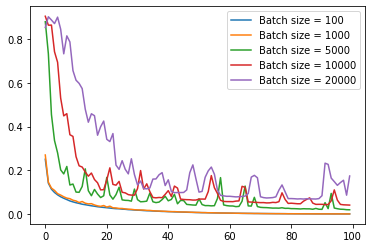

In [ ]:
sizes = [100, 1000, 5000, 10000, 20000]
for size in sizes:
  print("Batch size = ",size)
  NN = NeuralNet_DFA()
  NN.add_layer(Layer_DFA(784, 800, 10, ActivationTypes.tanh, 1, 9, 1e-3))
  NN.add_layer(FinalLayer_DFA(800, 10, ActivationTypes.sigmoid, 1, 9, 1e-3))
  train_errors = NN.train(X_train, Y_train, size,100,suppress_outputs=True)
  test_error = NN.test(X_test, Y_test)
  plt.plot(range(100),train_errors, label="Batch size = "+str(size))
  print("Training accuracy: ",100*(1-train_errors[-1]), "%,  Test accuracy: ", 100*(1-test_error),"%")
  print("")
plt.legend()
plt.show()

Fan out =  1
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:25


Training accuracy:  99.53999999999999 %,  Test accuracy:  96.71 %

Fan out =  4
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:25


Training accuracy:  99.81166666666667 %,  Test accuracy:  96.43 %

Fan out =  9
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:25


Training accuracy:  99.86833333333334 %,  Test accuracy:  96.1 %

Fan out =  16
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:25


Training accuracy:  99.67833333333334 %,  Test accuracy:  95.92 %



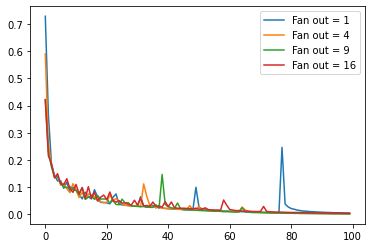

In [ ]:
fan_outs = [1, 4, 9, 16]
for fan_out in fan_outs:
  print("Fan out = ",fan_out)
  NN = NeuralNet_DFA()
  NN.add_layer(Layer_DFA(784, 800, 10, ActivationTypes.tanh, 1, fan_out, 1e-3))
  NN.add_layer(FinalLayer_DFA(800, 10, ActivationTypes.sigmoid, 1, fan_out, 1e-3))
  train_errors = NN.train(X_train, Y_train, 2000,100,suppress_outputs=True)
  test_error = NN.test(X_test, Y_test)
  plt.plot(range(100),train_errors, label="Fan out = "+str(fan_out))
  print("Training accuracy: ",100*(1-train_errors[-1]), "%,  Test accuracy: ", 100*(1-test_error),"%")
  print("")
plt.legend()
plt.show()

Fan in =  1
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:25


Training accuracy:  99.81 %,  Test accuracy:  96.75 %

Fan in =  4
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:24


Training accuracy:  98.67833333333334 %,  Test accuracy:  96.37 %

Fan in =  9
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:24


Training accuracy:  98.25666666666667 %,  Test accuracy:  95.93 %

Fan in =  16
Training the model...


0% [------------------------------] 100% | ETA: 00:00:00
Total time elapsed: 00:01:24


Training accuracy:  98.25500000000001 %,  Test accuracy:  96.22 %



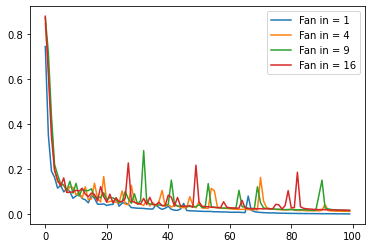

In [ ]:
fan_ins = [1, 4, 9, 16]
for fan_in in fan_outs:
  print("Fan in = ",fan_in)
  NN = NeuralNet_DFA()
  NN.add_layer(Layer_DFA(784, 800, 10, ActivationTypes.tanh, fan_in, 1, 1e-3))
  NN.add_layer(FinalLayer_DFA(800, 10, ActivationTypes.sigmoid, fan_in, 1, 1e-3))
  train_errors = NN.train(X_train, Y_train, 2000,100,suppress_outputs=True)
  test_error = NN.test(X_test, Y_test)
  plt.plot(range(100),train_errors, label="Fan in = "+str(fan_in))
  print("Training accuracy: ",100*(1-train_errors[-1]), "%,  Test accuracy: ", 100*(1-test_error),"%")
  print("")
plt.legend()
plt.show()

In [ ]:
NN = NeuralNet_DFA()
NN.add_layer(Layer_DFA(784, 800, 10, ActivationTypes.tanh, 1, 1, 1e-3))
NN.add_layer(FinalLayer_DFA(800, 10, ActivationTypes.sigmoid, 1, 1, 1e-3))
NN.train(X_train, Y_train, 1000,100)
NN.test(X_test, Y_test)

Training the model...
Epoch 1 : 10  [==================]
Errors = [ 0.3842333 0.1651667 0.1239000 0.0932167 0.0869500 0.0731833 0.0638333 0.0597333 0.0529000 0.0517667 ]
Average error =  0.1154883 

Epoch 11 : 20  [==================]
Errors = [ 0.0420833 0.0421000 0.0374500 0.0348167 0.0373667 0.0293000 0.0270500 0.0300167 0.0234667 0.0215167 ]
Average error =  0.0325167 

Epoch 21 : 30  [==================]
Errors = [ 0.0198167 0.0186167 0.0172500 0.0162500 0.0153833 0.0137667 0.0122833 0.0119167 0.0107833 0.0097333 ]
Average error =  0.0145800 

Epoch 31 : 40  [==================]
Errors = [ 0.0089333 0.0079333 0.0077500 0.0072000 0.0068333 0.0059167 0.0054833 0.0051167 0.0047333 0.0043833 ]
Average error =  0.0064283 

Epoch 41 : 50  [==================]
Errors = [ 0.0042500 0.0037167 0.0036500 0.0031500 0.0028000 0.0027167 0.0021833 0.0023000 0.0019500 0.0016833 ]
Average error =  0.0028400 

Epoch 51 : 60  [==================]
Errors = [ 0.0014667 0.0014667 0.0012000 0.0010333 0.

array(0.032)

In [ ]:
NN_BP = NeuralNet_BP()
NN_BP.add_layer(Layer_BP(784, 800, ActivationTypes.tanh, 1e-2))
NN_BP.add_layer(Layer_BP(800, 10, ActivationTypes.sigmoid, 1e-3))
NN_BP.train(X_train, Y_train, 1000,100)
NN_BP.test(X_test, Y_test)

Training the model...
Epoch 1 : 10  [==================]
Errors = [ 0.7311000 0.6410167 0.5627500 0.4835667 0.3869833 0.3607333 0.3479667 0.3408167 0.3368167 0.3335167 ]
Average error =  0.4525267 

Epoch 11 : 20  [==================]
Errors = [ 0.3317000 0.3295833 0.3281833 0.3271833 0.3262833 0.3252833 0.3247500 0.3243000 0.3236167 0.3230667 ]
Average error =  0.3263950 

Epoch 21 : 30  [==================]
Errors = [ 0.3223167 0.3220667 0.3217000 0.3213333 0.3207500 0.3204000 0.3201667 0.3198667 0.3195833 0.3191500 ]
Average error =  0.3207333 

Epoch 31 : 40  [==================]
Errors = [ 0.3191000 0.3188000 0.3184333 0.3182833 0.3174833 0.3174167 0.3170167 0.3167833 0.3167000 0.3166000 ]
Average error =  0.3176617 

Epoch 41 : 50  [==================]
Errors = [ 0.3163833 0.3161167 0.3154167 0.3145167 0.3125333 0.3085833 0.2755000 0.2301333 0.2269333 0.2255333 ]
Average error =  0.2841650 

Epoch 51 : 60  [==================]
Errors = [ 0.2245167 0.2240833 0.2234500 0.2231500 0.

array(0.2279)

In [ ]:
NN_BP = NeuralNet_BP()
NN_BP.add_layer(Layer_BP(784, 800, ActivationTypes.tanh, 1e-2))
NN_BP.add_layer(Layer_BP(800, 10, ActivationTypes.sigmoid, 1e-3))
NN_BP.train(X_train, Y_train, 1000,500)
NN_BP.test(X_test, Y_test)

Training the model...
Epoch 1 : 10  [==================]
Errors = [ 0.6829667 0.5754667 0.5056667 0.4949667 0.4904500 0.4878000 0.4861167 0.4841333 0.4813000 0.4697500 ]
Average error =  0.5158617 

Epoch 11 : 20  [==================]
Errors = [ 0.4177667 0.4078000 0.4052667 0.4042667 0.4034500 0.4025667 0.4014500 0.4007000 0.4002333 0.4000000 ]
Average error =  0.4043500 

Epoch 21 : 30  [==================]
Errors = [ 0.3999000 0.3990833 0.3985833 0.3984500 0.3979667 0.3978000 0.3972667 0.3970833 0.3963333 0.3953167 ]
Average error =  0.3977783 

Epoch 31 : 40  [==================]
Errors = [ 0.3939167 0.3927167 0.3910833 0.3851500 0.3551500 0.3376333 0.3317167 0.3284333 0.3261333 0.3248333 ]
Average error =  0.3566767 

Epoch 41 : 50  [==================]
Errors = [ 0.3239000 0.3228500 0.3221333 0.3216667 0.3208000 0.3203167 0.3201333 0.3199333 0.3197000 0.3193500 ]
Average error =  0.3210783 

Epoch 51 : 60  [==================]
Errors = [ 0.3191667 0.3190167 0.3189667 0.3188167 0.

array(0.2281)